In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import torch
from warnings import filterwarnings

filterwarnings("ignore")

In [2]:
try:
    # if use GPU, use it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {torch.cuda.get_device_name()} for training." if torch.cuda.is_available() else "Using CPU for training.")
except:
    print("No GPU found. Using CPU.")
    device = torch.device("cpu")

Using NVIDIA GeForce RTX 3060 Ti for training.


### Info About Data

In [3]:
df = pd.read_csv("train.csv")
df_copy = df.copy()
df_copy.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428


In [4]:
len(df_copy)

291142

In [5]:
df_copy.tail()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
291137,merchant_67083,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
291138,merchant_4263,202309,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
291139,merchant_11346,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3
291140,merchant_21397,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_168,Segment - 4,3
291141,merchant_66895,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 2,mcc_73,Segment - 4,3


In [6]:
df_copy.shape

(291142, 8)

In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291142 entries, 0 to 291141
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   merchant_id           291142 non-null  object
 1   month_id              291142 non-null  int64 
 2   merchant_source_name  291142 non-null  object
 3   settlement_period     291142 non-null  object
 4   working_type          291142 non-null  object
 5   mcc_id                291142 non-null  object
 6   merchant_segment      291142 non-null  object
 7   net_payment_count     291142 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 17.8+ MB


In [8]:
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
month_id,291142.0,202159.680860,104.214948,202001.0,202103.0,202201.0,202211.0,202309.0
net_payment_count,291142.0,415.384201,10820.674338,-1433.0,4.0,6.0,14.0,1160429.0


In [9]:
df_copy[['month_id', 'net_payment_count']].corr()

,month_id,net_payment_count
month_id,1.000000,0.006547
net_payment_count,0.006547,1.000000


In [10]:
value_counts_list = ["merchant_source_name", "settlement_period", "working_type", "merchant_segment"]

for i in value_counts_list:
    print(df_copy[i].value_counts())
    print("--------------------------")

merchant_source_name
Merchant Source - 1    164996
Merchant Source - 2    112541
Merchant Source - 3     13605
Name: count, dtype: int64
--------------------------
settlement_period
Settlement Period - 1    268906
Settlement Period - 3     20553
Settlement Period - 2      1683
Name: count, dtype: int64
--------------------------
working_type
Working Type - 6    128755
Working Type - 5    116793
Working Type - 2     40071
Working Type - 3      5204
Working Type - 4       255
Working Type - 1        64
Name: count, dtype: int64
--------------------------
merchant_segment
Segment - 4    280201
Segment - 2      6937
Segment - 3      3662
Segment - 1       342
Name: count, dtype: int64
--------------------------


In [11]:
def PlotBar(variable, df):
    data_ = df[variable]
    data_counts = data_.value_counts()
    
    plt.figure()
    plt.bar(data_counts.index, data_counts, color="red")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("Data Frequency - {}" .format(variable))
    plt.show()

In [12]:
def BoxPlot(variable, df):
    plt.boxplot(df[variable])
    plt.xlabel(variable)
    plt.ylabel("Value")
    plt.title("Boxplot for " + variable + " variable")
    plt.show()

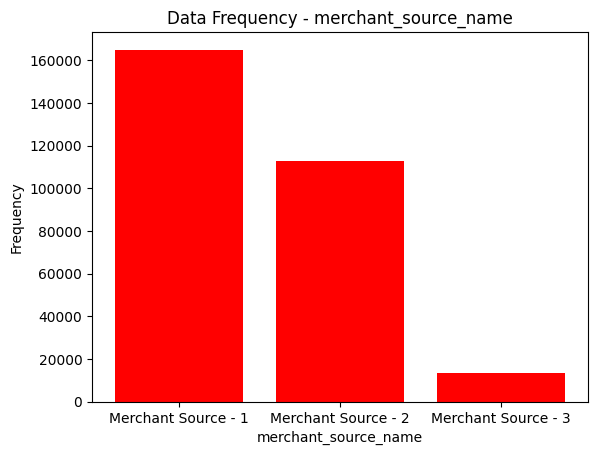

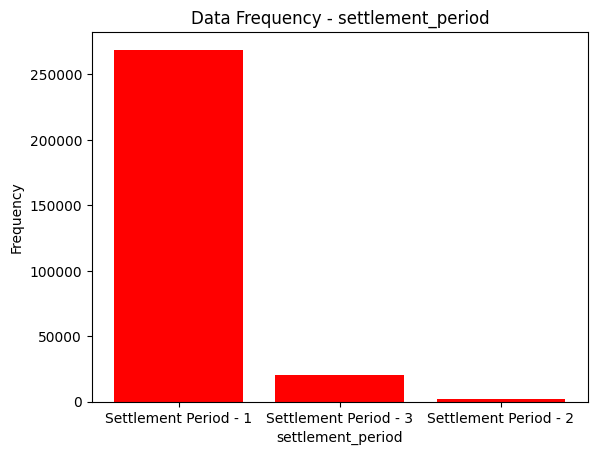

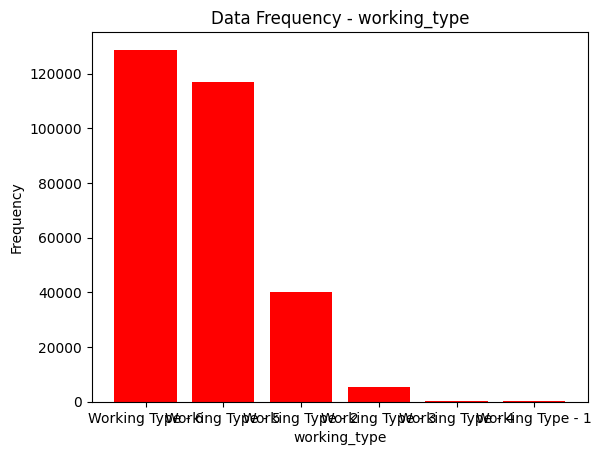

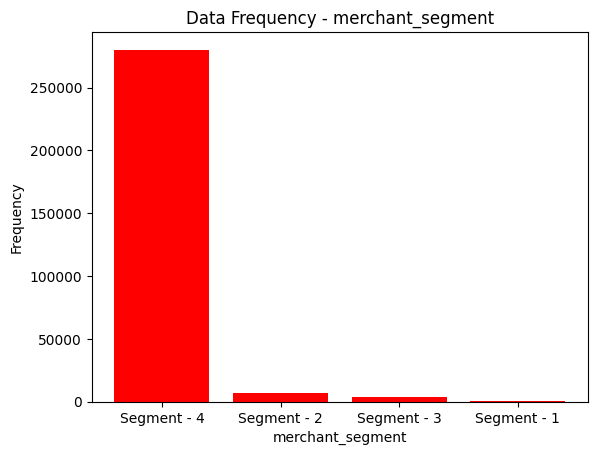

In [13]:
for i in value_counts_list:
    PlotBar(i, df_copy)

In [14]:
df_copy.drop("mcc_id", axis=1, inplace=True)

# Data PreProcessing

### Outlier Analysis

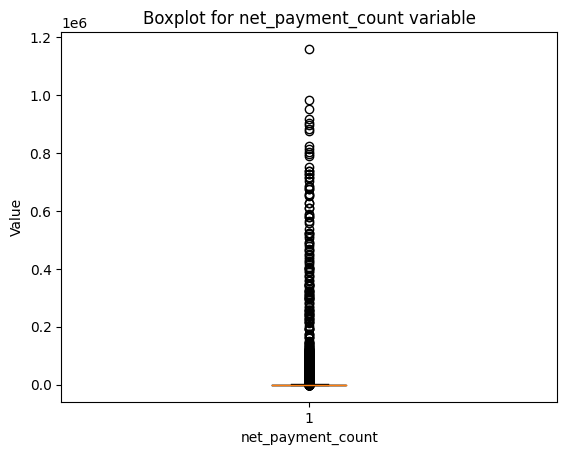

In [15]:
BoxPlot("net_payment_count", df_copy)

In [16]:
def BoxPlotMethod(col_name, df):
    df_variable = df[col_name]
    Q1 = df_variable.quantile(0.25)
    Q3 = df_variable.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    low_outlier_df = (df_variable < lower_limit)
    up_outlier_df = (df_variable > upper_limit)
    df_variable[low_outlier_df] = lower_limit
    df_variable[up_outlier_df] = upper_limit

In [17]:
BoxPlotMethod("net_payment_count", df_copy)

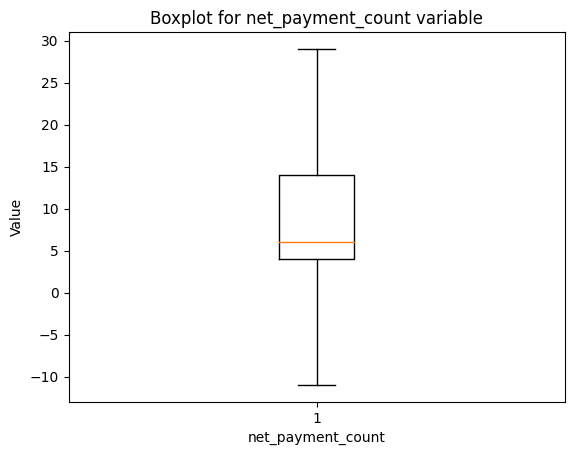

In [18]:
BoxPlot("net_payment_count", df_copy)

In [19]:
len(df_copy)

291142

### Encoding and Scaling

In [20]:
df_copy.head()

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,29
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,29
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,29
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,29
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,29


In [21]:
encoding_df = df_copy[['merchant_id', 'merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment']]
scale_df = df_copy[['net_payment_count']]

In [22]:
lbe = LabelEncoder()
encoding_df['merchant_id'] = lbe.fit_transform(encoding_df['merchant_id'])

In [23]:
encoding_col_list = ['merchant_id', 'merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment']

for i in encoding_col_list:
    if i == 'merchant_id':
        continue
    encoding_df = pd.get_dummies(encoding_df, columns=[i], prefix=[i])

In [24]:
encoding_df.head()

,merchant_id,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,working_type_Working Type - 4,working_type_Working Type - 5,working_type_Working Type - 6,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4
0,14423,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False
1,14423,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False
2,14423,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False
3,14423,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False
4,14423,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False


In [25]:
encoding_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291142 entries, 0 to 291141
Data columns (total 17 columns):
 #   Column                                    Non-Null Count   Dtype
---  ------                                    --------------   -----
 0   merchant_id                               291142 non-null  int64
 1   merchant_source_name_Merchant Source - 1  291142 non-null  bool 
 2   merchant_source_name_Merchant Source - 2  291142 non-null  bool 
 3   merchant_source_name_Merchant Source - 3  291142 non-null  bool 
 4   settlement_period_Settlement Period - 1   291142 non-null  bool 
 5   settlement_period_Settlement Period - 2   291142 non-null  bool 
 6   settlement_period_Settlement Period - 3   291142 non-null  bool 
 7   working_type_Working Type - 1             291142 non-null  bool 
 8   working_type_Working Type - 2             291142 non-null  bool 
 9   working_type_Working Type - 3             291142 non-null  bool 
 10  working_type_Working Type - 4             29

In [26]:
encoding_df = encoding_df.astype('int64')

In [27]:
encoding_df.head()

,merchant_id,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,working_type_Working Type - 4,working_type_Working Type - 5,working_type_Working Type - 6,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4
0,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
1,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
2,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
3,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
4,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0


In [28]:
scale_df = preprocessing.scale(scale_df)

In [29]:
scale_df

array([[ 1.94405818],
       [ 1.94405818],
       [ 1.94405818],
       ...,
       [-0.78251365],
       [-0.78251365],
       [-0.78251365]])

In [30]:
scale_df = pd.DataFrame(scale_df)

In [31]:
scale_df.rename(columns={0 : 'net_payment_count'}, inplace=True)

In [32]:
scale_df.head()

,net_payment_count
0,1.944058
1,1.944058
2,1.944058
3,1.944058
4,1.944058


In [33]:
month_df = df_copy[["month_id"]]
month_df.head()

,month_id
0,202307
1,202301
2,202305
3,202308
4,202302


In [34]:
inter_merge = pd.concat([month_df, scale_df], axis=1)
merge_df = pd.concat([encoding_df, inter_merge], axis=1)

In [35]:
merge_df.head()

,merchant_id,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,working_type_Working Type - 4,working_type_Working Type - 5,working_type_Working Type - 6,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,month_id,net_payment_count
0,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202307,1.944058
1,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202301,1.944058
2,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202305,1.944058
3,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202308,1.944058
4,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202302,1.944058


In [36]:
merge_df.to_csv('preprocessing_data.csv', index=False)

# Modelling

In [3]:
iyzico_df = pd.read_csv('preprocessing_data.csv')
iyzico_df.head()

,merchant_id,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,working_type_Working Type - 4,working_type_Working Type - 5,working_type_Working Type - 6,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,month_id,net_payment_count
0,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202307,1.944058
1,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202301,1.944058
2,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202305,1.944058
3,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202308,1.944058
4,14423,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,202302,1.944058


In [4]:
len(iyzico_df)

291142

In [5]:
iyzico_df.insert(1, 'month_id', iyzico_df.pop('month_id'))

In [6]:
iyzico_df = iyzico_df.sort_values(["merchant_id", "month_id"]).reset_index(drop=True)

In [7]:
print("Min-max month: ", iyzico_df["month_id"].min(), iyzico_df["month_id"].max())

Min-max month:  202001 202309


In [8]:
x = iyzico_df.drop("net_payment_count", axis=1)
y = iyzico_df[["net_payment_count"]]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

## KNN

In [43]:
knn_model = KNeighborsRegressor().fit(x_train, y_train)
knn_model

KNeighborsRegressor()

In [44]:
knn_model.n_neighbors

5

In [45]:
knn_model.effective_metric_

'euclidean'

In [46]:
y_pred = knn_model.predict(x_test)
mean_absolute_error(y_test, y_pred)

0.49643304836695673

#### Model Tuning

In [49]:
knn_tuned_model = KNeighborsRegressor(n_neighbors = 2)
knn_tuned_model.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [50]:
y_pred = knn_tuned_model.predict(x_test)
mean_absolute_error(y_test, y_pred)

0.3396323947964047

KNN MAE -> 0.33

## CART

In [51]:
cart_model = DecisionTreeRegressor(min_samples_split = 2)
cart_model.fit(x_train, y_train)

DecisionTreeRegressor()

In [52]:
y_pred =cart_model.predict(x_test)
mean_absolute_error(y_test, y_pred)

0.2590411991767111

## Bagged Trees

In [53]:
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(x_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [54]:
bag_model.n_estimators

10

In [55]:
bag_model.estimators_

[DecisionTreeRegressor(random_state=333077612),
 DecisionTreeRegressor(random_state=1701878307),
 DecisionTreeRegressor(random_state=156565695),
 DecisionTreeRegressor(random_state=2093462174),
 DecisionTreeRegressor(random_state=966150220),
 DecisionTreeRegressor(random_state=1098264345),
 DecisionTreeRegressor(random_state=1049031515),
 DecisionTreeRegressor(random_state=1932878231),
 DecisionTreeRegressor(random_state=933110002),
 DecisionTreeRegressor(random_state=479320778)]

In [56]:
bag_model.estimators_samples_

[array([130496,  69321,  43424, ...,  26345,  63406, 125325]),
 array([ 25619, 154992, 206847, ...,  90170, 231407,  79546]),
 array([200667, 109855,  52550, ...,  63010,  76134,  98847]),
 array([115788, 230627,  24356, ..., 159719, 222597,   6661]),
 array([ 94026,  40129, 198884, ..., 191772, 128847,  52747]),
 array([ 19630,  60802, 118498, ...,  19459, 160198, 220875]),
 array([178191,  68406, 125089, ...,  21265, 153706, 122661]),
 array([ 34124,  98753,  74408, ..., 192879,  26398, 174710]),
 array([ 46989, 183993, 175243, ..., 203785, 225783, 222255]),
 array([206032, 102473,  49419, ...,  14899, 159937,  66430])]

In [57]:
bag_model.estimators_features_

[array([12, 12, 17, 11, 12, 13, 11, 15,  3, 15,  0, 12,  1, 15, 15,  0,  7,
        12]),
 array([ 3,  3, 11,  8, 15,  8, 14,  6,  3, 10, 17, 17,  9, 14, 16, 15,  9,
         3]),
 array([13, 13, 11, 10,  2, 11,  6,  3,  3,  2, 14, 13, 14, 17, 12,  5,  2,
        14]),
 array([ 5, 16,  3, 16,  9, 16,  4, 10,  9,  8,  2,  6, 15, 11,  9,  7, 10,
        15]),
 array([12,  1, 11,  6,  5,  9,  8,  6,  3,  9, 14, 12,  5, 14,  8, 13,  7,
        15]),
 array([ 6, 11, 11, 11,  1,  4,  3, 16, 14, 10,  6,  8, 16,  1, 14, 14,  4,
         5]),
 array([ 1,  6,  1,  3,  0,  9, 12,  0, 11,  6, 12, 12,  9,  6,  7,  5, 12,
         1]),
 array([17, 10, 12,  4, 16, 15,  7,  5,  3,  6,  4,  3,  6,  8, 11,  9,  3,
         0]),
 array([ 3, 14, 14, 11, 17, 13,  0, 16,  4,  6, 13, 10,  3, 11,  9, 11, 12,
        14]),
 array([10,  7,  3, 10,  5, 13,  9,  0, 15, 17,  9, 16, 17, 17,  5, 10, 12,
         7])]

In [58]:
y_pred = bag_model.predict(x_test)
mean_absolute_error(y_test, y_pred)

0.4825055851639806

#### Model Tuning

In [59]:
bag_params = {"n_estimators": range(2,20)}
bag_cv_model = GridSearchCV(bag_model, bag_params, cv = 10)
bag_cv_model.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=BaggingRegressor(bootstrap_features=True),
             param_grid={'n_estimators': range(2, 20)})

In [60]:
bag_cv_model.best_params_

{'n_estimators': 18}

In [62]:
bag_tuned_model = BaggingRegressor(n_estimators = 6, random_state = 45)
bag_tuned_model.fit(x_train, y_train)

BaggingRegressor(n_estimators=6, random_state=45)

In [63]:
y_pred = bag_tuned_model.predict(x_test)
mean_absolute_error(y_test, y_pred)

0.26755794288239243

## Random Forests

In [10]:
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
y_pred = rf_model.predict(x_test)
mean_absolute_error(y_test, y_pred)

0.25336084269124304

Text(0.5, 0, 'Değişken Önem Düzeyleri')

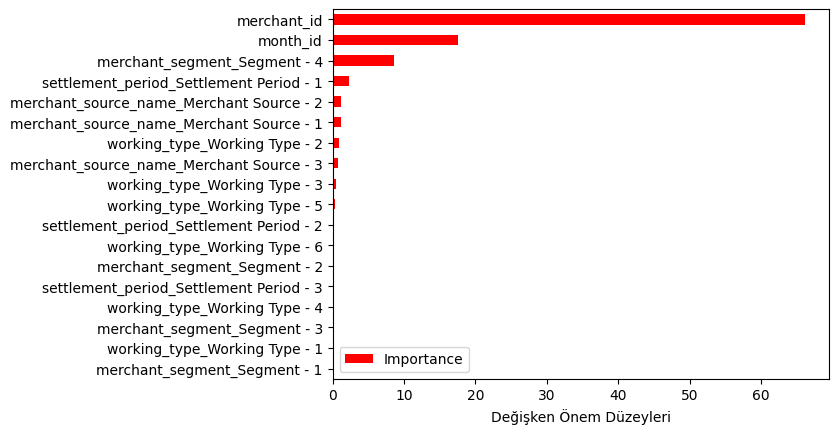

In [66]:
Importance = pd.DataFrame({"Importance": rf_model.feature_importances_*100},
                         index = x_train.columns)
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")
plt.xlabel("Değişken Önem Düzeyleri")

## MLP

In [67]:
mlp_model = MLPRegressor(hidden_layer_sizes = (300, 450, 450, 200), activation='relu')
mlp_model.fit(x_train, y_train)

MLPRegressor(hidden_layer_sizes=(300, 450, 450, 200))

In [68]:
mlp_model.n_layers_

6

In [69]:
mlp_model.hidden_layer_sizes

(300, 450, 450, 200)

In [70]:
y_pred = mlp_model.predict(x_test)
mean_absolute_error(y_test, y_pred)

0.8292482164460501

# Comparison of All Models

In [77]:
models = [
    knn_model,
    knn_tuned_model,
    cart_model,
    bag_model,
    bag_tuned_model,
    rf_model,
    mlp_model
]

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    print("-"*28)
    print(names + ":" )
    print("Mean Absolute Error: {}".format(mae))

----------------------------
KNeighborsRegressor:
Mean Absolute Error: 0.49643304836695673
----------------------------
KNeighborsRegressor:
Mean Absolute Error: 0.3396323947964047
----------------------------
DecisionTreeRegressor:
Mean Absolute Error: 0.2590411991767111
----------------------------
BaggingRegressor:
Mean Absolute Error: 0.4825055851639806
----------------------------
BaggingRegressor:
Mean Absolute Error: 0.26755794288239243
----------------------------
RandomForestRegressor:
Mean Absolute Error: 0.25336084269124304
----------------------------
MLPRegressor:
Mean Absolute Error: 0.8292482164460501
